# Problem Session 9
## Classifying Pumpkin Seeds II

In this notebook you continue to work with the pumpkin seed data from <a href="https://link.springer.com/article/10.1007/s10722-021-01226-0">The use of machine learning methods in classification of pumpkin seeds (Cucurbita pepo L.)</a> by Koklu, Sarigil and Ozbek (2021).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

#### 1. Load then prepare the data


- Load the data stored in `Pumpkin_Seeds_Dataset.xlsx` in the `Data` folder,
- Create a column `y` where `y=1` if `Class=Ürgüp Sivrisi` and `y=0` if `Class=Çerçevelik` and
- Make a train test split setting $10\%$ of the data aside as a test set.

##### Sample Solution

In [2]:
seeds = pd.read_excel("../../Data/Pumpkin_Seeds_Dataset.xlsx")

seeds['y'] = 0

seeds.loc[seeds.Class=='Ürgüp Sivrisi', 'y']=1

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
seeds_train, seeds_test = train_test_split(seeds.copy(),
                                              shuffle=True,
                                              random_state=123,
                                              test_size=.1,
                                              stratify=seeds.y.values)

#### 2. Refresh your memory

If you need to refresh your memory on these data and the problem, you may want to look at a small subset of the data, look back on `Problem Session 8` and/or browse Figure 5 and Table 1 of this paper, <a href="pumpkin_seed_paper.pdf">pumpkin_seed_paper.pdf</a>

We will store our different model accuracies in a dictionary for easy comparson at the end of the notebook.  I am starting it off with the two best models from problem session 8.

In [5]:
model_accs = {
         "knn" : 0.886,
         "log_reg": 0.867
            }

##### Sample Solution

In [6]:
seeds_train.sample(5)

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class,y
1072,103248,1253.276,489.6105,269.4285,104423,362.5734,0.8350,0.9887,0.6606,0.8260,1.8172,0.7405,Çerçevelik,0
1265,61712,1122.674,370.2319,214.4666,62992,280.3108,0.8151,0.9797,0.7008,0.6153,1.7263,0.7571,Çerçevelik,0
2413,88135,1208.556,492.3325,230.7307,89051,334.9880,0.8834,0.9897,0.6898,0.7583,2.1338,0.6804,Ürgüp Sivrisi,1
759,66086,992.483,388.6784,217.6789,66864,290.0747,0.8285,0.9884,0.7251,0.8431,1.7856,0.7463,Çerçevelik,0
617,68156,1064.093,387.2451,225.5328,69811,294.5826,0.8129,0.9763,0.6553,0.7564,1.7170,0.7607,Çerçevelik,0


#### 3. Principal components analysis (PCA)

One way you may use PCA is as a data preprocessing step for supervised learning tasks. In this problem you will try it as a preprocessing step for the pumpkin seed data and see if this preprocessing step helps your model outperform the models from `Problem Session 8`.

##### a. 

Run the training data through PCA with two components and then plot the resulting principal values. Color each point by its class.

<i>Hint: Remember to scale the data before running it through PCA</i>.

##### Sample Solution

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [8]:
features = seeds_train.columns[:-2]

pca = Pipeline([('scale', StandardScaler()),
                   ('pca', PCA(2))])

pca_values = pca.fit_transform(seeds_train[features])

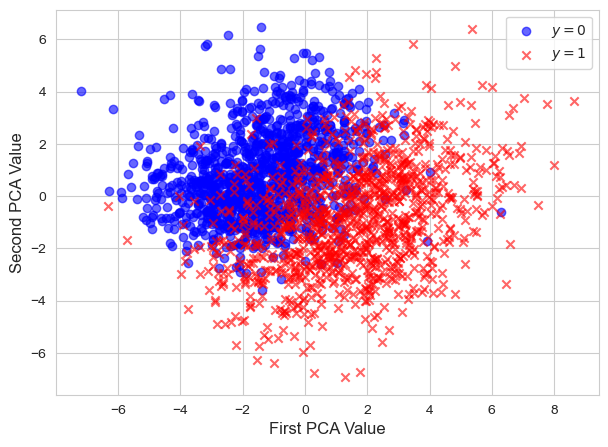

In [9]:
plt.figure(figsize=(7,5))

plt.scatter(pca_values[seeds_train.y==0, 0], 
            pca_values[seeds_train.y==0, 1],
            color = 'b',
            label="$y=0$",
            alpha=.6)

plt.scatter(pca_values[seeds_train.y==1, 0], 
            pca_values[seeds_train.y==1, 1],
            color='r',
            marker='x',
            label="$y=1$",
            alpha=.6)

plt.legend(fontsize=10)

plt.xlabel("First PCA Value", fontsize=12)
plt.ylabel("Second PCA Value", fontsize=12)

plt.show()

##### b.

How does the PCA with only two componenets appear to separate the data?

##### Sample Solution

While not perfect separation the two classes do seem to largely live in separate areas of the plot.

##### c.

Run 5-fold cross-validation below to find the optimal value of $k$ for a $k$ nearest neighbors model fit on the first and second PCA values. What is the optimal $k$ and the associated average cross-validation accuracy? How does this compare to the accuracies from `Problem Session 8`?

##### Sample Solution

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [11]:
n_splits=5
kfold = StratifiedKFold(n_splits,
                           shuffle=True,
                           random_state=216)

In [12]:
neighbors = range(1, 51)

pca_2_accs = np.zeros((n_splits, len(neighbors)))

# Note:  switching to using "enumerate" from this point in the bootcamp forward.
for i,(train_index, test_index) in enumerate(kfold.split(seeds_train, seeds_train.y)):
    print("CV Split", i)
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    ## Note, putting the PCA here speeds up the loop
    pca_pipe = Pipeline([('scale', StandardScaler()),
                               ('pca', PCA(2))])
    
    
    pca_tt = pca_pipe.fit_transform(seeds_tt[features].values)
    pca_ho = pca_pipe.transform(seeds_ho[features].values)
    
    
    for j, n_neighbors in enumerate(neighbors):
        # No need to scale knn first since PCA is handling that
        knn = KNeighborsClassifier(n_neighbors)
        
        knn.fit(pca_tt, seeds_tt.y.values)
        
        pred = knn.predict(pca_ho)
        
        pca_2_accs[i,j] = accuracy_score(seeds_ho.y.values, pred)

CV Split 0
CV Split 1
CV Split 2
CV Split 3
CV Split 4


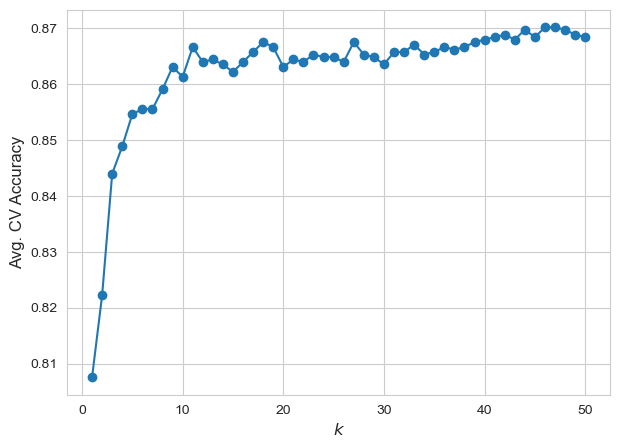

In [13]:
plt.figure(figsize=(7,5))

plt.plot(neighbors, 
         np.mean(pca_2_accs, axis=0),
         '-o')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

In [14]:
print(f'The best mean CV accuracy of {np.max(np.mean(pca_2_accs, axis=0)):.3f} was achieved with k = {neighbors[np.argmax(np.mean(pca_2_accs, axis=0))]}' )

The best mean CV accuracy of 0.870 was achieved with k = 46


##### d.

We can think of the number of components used in PCA as another hyperparameter we can tune.

Fill in the missing code below to find the optimal number of components and $k$ pairing for this problem. What is the best average cross-validation accuracy?

##### Sample Solution

In [15]:
neighbors = range(1, 51)
comps = range(2,6)

pca_accs = np.zeros((n_splits, len(comps), len(neighbors)))

for i,(train_index, test_index) in enumerate(kfold.split(seeds_train, seeds_train.y)):
    print("CV Split", i)
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    for j, n_comps in enumerate(comps):
        pca_pipe = Pipeline([('scale', StandardScaler()),
                               ('pca', PCA(n_comps))])
    
    
        pca_tt = pca_pipe.fit_transform(seeds_tt[features].values)
        pca_ho = pca_pipe.transform(seeds_ho[features].values)
        
        for k, n_neighbors in enumerate(neighbors):
            knn = KNeighborsClassifier(n_neighbors)
            
            knn.fit(pca_tt,
                    seeds_tt.y.values)

            pred = knn.predict(pca_ho)

            pca_accs[i,j,k] = accuracy_score(seeds_ho.y.values, pred)

CV Split 0
CV Split 1
CV Split 2
CV Split 3
CV Split 4


In [16]:
max_index = np.unravel_index(np.argmax(np.mean(pca_accs, axis=0), axis=None), 
                                       np.mean(pca_accs, axis=0).shape)


print(f"The pair with the highest AVG CV Accuracy was k = {neighbors[max_index[1]]} and number of components = {comps[max_index[0]]:.1f}")
print(f"The highest AVG CV Accuracy was {np.max(np.mean(pca_accs, axis=0)):.3f}")

The pair with the highest AVG CV Accuracy was k = 15 and number of components = 4.0
The highest AVG CV Accuracy was 0.887


In [17]:
model_accs['pca_knn'] = 0.887

#### 4. Trying Bayes based classifiers

Build LDA, QDA and naive Bayes' models on these data by filling in the missing code for the cross-validation below. 

Do these outperform your PCA-$k$-NN model from above?=

##### Sample Solution

In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [19]:
bayes_accs = np.zeros((n_splits, 3))

for i, (train_index, test_index) in enumerate(kfold.split(seeds_train, seeds_train.y)):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    ## Linear Discriminant Analysis
    lda = Pipeline([('scale', StandardScaler()),
                    ('lda', LinearDiscriminantAnalysis())])
    
    lda.fit(seeds_tt[features].values,
               seeds_tt.y.values)
    lda_pred = lda.predict(seeds_ho[features].values)
    
    bayes_accs[i, 0] = accuracy_score(seeds_ho.y.values,
                                         lda_pred)
    
    ## Quadratic Discriminant Analysis
    qda = Pipeline([('scale', StandardScaler()),
                    ('qda', QuadraticDiscriminantAnalysis())])
    
    qda.fit(seeds_tt[features].values,
               seeds_tt.y.values)
    
    qda_pred = qda.predict(seeds_ho[features].values)
    
    bayes_accs[i, 1] = accuracy_score(seeds_ho.y.values,
                                         qda_pred)
    
    
    ## Gaussian Naive Bayes
    nb = Pipeline([('scale', StandardScaler()),
                    ('NB', GaussianNB())])
    
    nb.fit(seeds_tt[features].values,
              seeds_tt.y.values)
    
    nb_pred = nb.predict(seeds_ho[features].values)
    
    bayes_accs[i, 2] = accuracy_score(seeds_ho.y.values,
                                         nb_pred)

/opt/homebrew/Caskroom/miniforge/base/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/discriminant_a

In [20]:
np.mean(bayes_accs, axis=0)

array([0.88177778, 0.88622222, 0.87022222])

In [21]:
model_accs['qda'] = np.round(np.mean(bayes_accs, axis=0)[1],3)

In [22]:
model_accs

{'knn': 0.886, 'log_reg': 0.867, 'pca_knn': 0.887, 'qda': np.float64(0.886)}

Comparable to the PCA-$k$-NN model.

#### 5. A support vector machine classifier

In this problem you will work to build a support vector classifier on these data.

##### a.

Start by importing the support vector classifier from `sklearn`. Note that these data are not close to being linearly separable so we will not want `LinearSVC`.

In [23]:
from sklearn.svm import SVC

##### b.

You will now perform hyperparameter tuning on the `C` parameter of the support vector classifier. Fill in the missing pieces of the code below to perform 5-fold cross-validation for different values of `C`.

##### Sample Solution

In [24]:
## set the number of CV folds
n_splits = 5

## Make the kfold object
kfold = StratifiedKFold(n_splits, 
                        random_state=2013, 
                        shuffle=True)


## the values of C you will try
Cs = [.01, .1, 1, 10, 25, 50, 75, 100, 125, 150]

## this will hold the CV accuracies
C_accs1 = np.zeros((n_splits, len(Cs)))


## the cross-validation
for i,(train_index, test_index) in enumerate(kfold.split(seeds_train, seeds_train.y)):
    seeds_tt = seeds_train.iloc[train_index]
    seeds_ho = seeds_train.iloc[test_index]
    
    for j,C in enumerate(Cs):
        pipe = Pipeline([('scale', StandardScaler()),
                            ('svm', SVC(C=C))])
    
        pipe.fit(seeds_tt[features],
                    seeds_tt.y)
    
        pred = pipe.predict(seeds_ho[features])

        C_accs1[i, j] = accuracy_score(seeds_ho.y, pred)

##### c.

Plot the average cross-validation accuracy against the $\log$ of `C`.

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/folders/14/6_njfgsd63b_nr13v4mq3fb00000gn/T/ipykernel_91228/4212978257.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\log(C)$", fontsize=12)


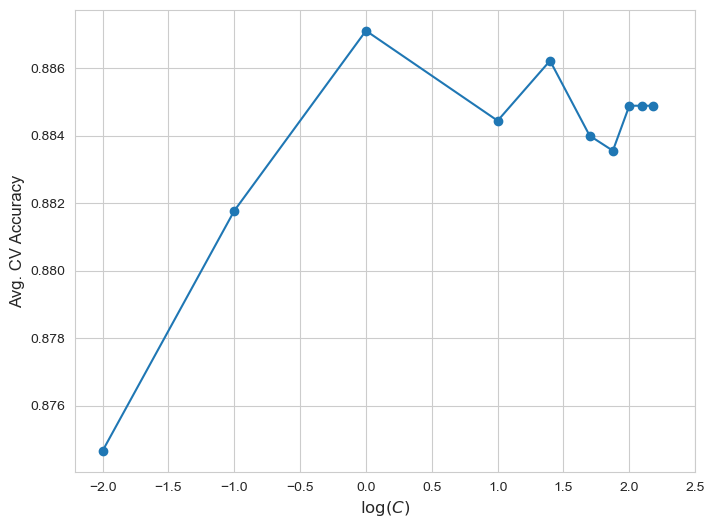

In [25]:
plt.figure(figsize = (8,6))

plt.plot(np.log10(np.array(Cs)), 
         np.mean(C_accs1, axis=0), 
         '-o')

plt.xlabel("$\log(C)$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)
plt.xticks(np.arange(-2,3,.5),fontsize=10)
plt.yticks(fontsize=10)

plt.show()

##### e.

What was the optimal value of `C`, what was the average cross-validation accuracy for this value of `C`?

In [26]:
mean_cv_accuracy = np.mean(C_accs1, axis=0)
optimal_index = np.argmax(mean_cv_accuracy)
optimal_C = Cs[optimal_index]
optimal_accuracy = mean_cv_accuracy[optimal_index]

print(f"The optimal C was {optimal_C} which gave a mean CV accuracy of {optimal_accuracy:.3f}")

The optimal C was 1 which gave a mean CV accuracy of 0.887


In [27]:
model_accs['svc'] = np.round(optimal_accuracy,3)

In [28]:
model_accs

{'knn': 0.886,
 'log_reg': 0.867,
 'pca_knn': 0.887,
 'qda': np.float64(0.886),
 'svc': np.float64(0.887)}

These models all perform quite similarly!  It is very possible that we just don't have a set of features which are sufficiently discriminating to do any better.  Let's actually find which two training samples with different class are closest to each other.

In [30]:
import numpy as np
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler

# Scale the feature data
scaler = StandardScaler()
scaled_X = scaler.fit_transform(seeds_train[features])

# Construct a KDTree for fast nearest-neighbor search
kdt = KDTree(scaled_X, leaf_size=30, metric='euclidean')

# Find the two nearest neighbors for each point
distances, indices = kdt.query(scaled_X, k=2, return_distance=True)

# Sort indices by nearest neighbor distance (excluding self-distance)
sorted_indices = np.argsort(distances[:, 1])  # Only the 2nd column matters

# Reorder neighbor pairs accordingly
sorted_pairs = indices[sorted_indices]

# Identify the first pair with different class labels
labels = seeds_train.y.values
mismatch_index = np.argmax(labels[sorted_pairs[:, 0]] != labels[sorted_pairs[:, 1]])

# Retrieve the mismatched pair
index_1, index_2 = sorted_pairs[mismatch_index]

# Display the mismatched data points
seeds_train.iloc[[index_1, index_2], :]

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness,Class,y
559,76663,1072.660,417.3221,235.3982,77341,312.4266,0.8257,0.9912,0.7342,0.8373,1.7728,0.7486,Çerçevelik,0
1343,76262,1067.326,415.7299,234.0947,76927,311.6084,0.8264,0.9914,0.7282,0.8412,1.7759,0.7495,Ürgüp Sivrisi,1


We can see that these are extremely close to each other despite having different classes.  If there are many such examples, it may be impossible for us to get a better classification accuracy.

It is possible that these two cultivars could be very different genetically, very different morphologically as adult plants, and yet have seeds which are similar enough that some of them cannot be distinguished from each other based exclusively on their geometry.  

It is also possible that the seeds **are** distinct, but that some of our samples have been mislabeled.  This would also spell doom for any improved accuracy on this dataset.

#### 6. (OPTIONAL) LDA for supervised dimensionality reduction

Only do this section if you have time.

While we introduced linear discriminant analysis (LDA) as a classification algorithm, it was originally proposed by Fisher as a supervised dimension reduction technique, <a href="https://digital.library.adelaide.edu.au/dspace/bitstream/2440/15227/1/138.pdf">https://digital.library.adelaide.edu.au/dspace/bitstream/2440/15227/1/138.pdf</a>. In particular, the initial goal was to project the features, $X$, corresponding to a binary output, $y$, onto a single dimension which best separates the possible classes. This single dimension has come to been known as <i>Fisher's discriminant</i>.

In the case of two classes, we are projecting onto the line connecting the class sample means.  However we are **not** projecting orthogonally with respect to the Euclidean metric!  As discussed in the week 8 math hour, we will end up doing orthogonal projection with respect to the Mahalanobis metric of the learned LDA covariance matrix.

Walk through the code below to perform this supervised dimension reduction technique on these data.

##### a.

First make a validation set from the training set for demonstration purposes.

##### Sample Solution

In [31]:
## First we make a validation set for demonstration purposes
seed_tt, seeds_val = train_test_split(seeds_train.copy(),
                                               shuffle=True,
                                               random_state=302,
                                               test_size = .2,
                                               stratify = seeds_train.y)

##### b.

Now make a pipeline that first scales the data and ends with linear discriminant analysis. Then fit the pipeline.

##### Sample Solution

In [32]:
pipe = Pipeline([('scale', StandardScaler()),
                    ('lda', LinearDiscriminantAnalysis())])

In [33]:
pipe.fit(seeds_tt[features], 
         seeds_tt.y.values)

Pipeline(steps=[('scale', StandardScaler()),
                ('lda', LinearDiscriminantAnalysis())])

##### c. 

Now calculate the Fisher discriminant by using `transform` with the pipeline you fit in <i>b.</i>

##### Sample Solution

In [34]:
fish = pipe.transform(seeds_tt[features])
fish

array([[-0.57662575],
       [ 0.56668948],
       [ 2.52564344],
       ...,
       [ 0.51097132],
       [-0.8748063 ],
       [-2.66903043]], shape=(1800, 1))

##### d. 

To visualize how LDA separated the two classes while projecting the 12 dimensional data onto a one dimensional subspace you can plot a histogram of the Fisher discriminant colored by the pumpkin seed class of the observation.

##### Sample Solution

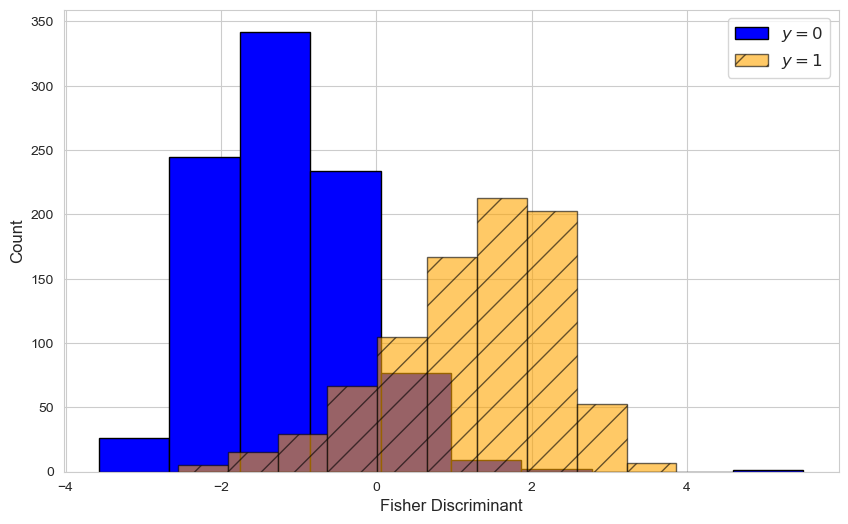

In [35]:
plt.figure(figsize=(10,6))

plt.hist(fish[seeds_tt.y==0], 
         color='blue',
         edgecolor="black",
         label="$y=0$")

plt.hist(fish[seeds_tt.y==1], 
         color='orange', 
         hatch='/', 
         alpha=.6,
         edgecolor="black",
         label="$y=1$")

plt.xlabel("Fisher Discriminant", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(fontsize=12)

plt.show()

##### e.

While there is some separation between the two classes, it is not perfect, this should be expected based on the exploratory data analysis you did in `Problem Session 8`.

We could use this discriminant in order to make classifications, for example by setting a simple cutoff value or as input into a different classification algorithm.

However, it is important to note that the LDA algorithm maximizes the separation of the two classes among observations of the training set. It is possible that separation would not be as good for data the algorithm was not trained on.

In this example we can visually inspect by plotting a histogram of the Fisher discriminant values for the validation set we created. Does the separation seem as pronounced on the validation data?

##### Sample Solution

In [36]:
fish_val = pipe.transform(seeds_val[features])

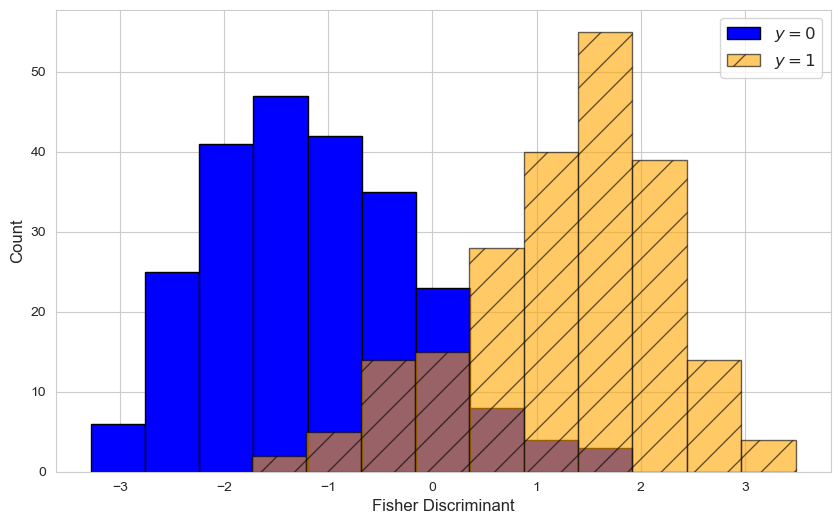

In [37]:
plt.figure(figsize=(10,6))

plt.hist(fish_val[seeds_val.y==0], 
         color='blue',
         edgecolor="black",
         label="$y=0$")

plt.hist(fish_val[seeds_val.y==1], 
         color='orange', 
         hatch='/', 
         alpha=.6,
         edgecolor="black",
         label="$y=1$")

plt.xlabel("Fisher Discriminant", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend(fontsize=12)

plt.show()

There appears to be a little more overlap, but overall the separation appears similar on the validation set.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)